## Imports

In [1]:
import sklearn
import numpy as np
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from prettytable import PrettyTable
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
tqdm_notebook.get_lock().locks = []
# !pip install sweetviz
# import sweetviz as sv
import concurrent.futures
from copy import deepcopy
from functools import partial
from itertools import combinations
import random
from random import randint, uniform
import gc
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from itertools import combinations
from sklearn.impute import SimpleImputer
import xgboost as xg
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,mean_squared_log_error, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, log_loss
from sklearn.cluster import KMeans
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
!pip install gap-stat
from gap_statistic.optimalK import OptimalK
from scipy import stats
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import boxcox
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
!pip install optuna
import optuna
import xgboost as xgb
!pip install catboost
!pip install lightgbm --install-option=--gpu --install-option="--boost-root=C:/local/boost_1_69_0" --install-option="--boost-librarydir=C:/local/boost_1_69_0/lib64-msvc-14.1"
import lightgbm as lgb
!pip install category_encoders
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier
!pip install -U imbalanced-learn
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from catboost import Pool
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns',None)



Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --install-option


/Users/wwaya/Documents/miniconda3/envs/42AI-sucho/lib/python3.11/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## 2.1 DATA

In [9]:
# train=pd.read_csv('/kaggle/input/playground-series-s3e23/train.csv')
# test=pd.read_csv('/kaggle/input/playground-series-s3e23/test.csv')
# original=pd.read_csv("/kaggle/input/software-defect-prediction/jm1.csv")

train = pd.read_csv("./playground-series-s3e23/train.csv")
test = pd.read_csv("./playground-series-s3e23/test.csv")
original = pd.read_csv("./software-defect-prediction/jm1.csv")

train.drop(columns=["id"], inplace=True)
test.drop(columns=["id"], inplace=True)

cols = ["uniq_Op", "uniq_Opnd", "total_Op", "total_Opnd", "branchCount"]


def convert(x):
    try:
        return float(x)
    except ValueError:
        return np.nan


for col in cols:
    original[col] = original[col].apply(convert)
original = original.dropna()
train_copy = train.copy()
test_copy = test.copy()
original_copy = original.copy()

# original 칼럼 추가 후 1로 값 세팅
original["original"] = 1

# original 칼럼 추가 후 0로 값 세팅
train["original"] = 0
test["original"] = 0

# 합침
train = pd.concat([train, original], axis=0)
train.reset_index(inplace=True, drop=True)
train.head()


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects,original
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,0.09,302.71,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False,0
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,0.05,52.04,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False,0
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,0.07,97.45,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False,0
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,0.03,26.31,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True,0
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,0.02,20.31,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False,0


## 2.2 MISSING VALUE CHECKS

In [3]:
table = PrettyTable()

table.field_names = [
    "Feature",
    "Data Type",
    "Train Missing %",
    "Test Missing %",
    "Original Missing%",
]
for column in train_copy.columns:
    data_type = str(train_copy[column].dtype)
    non_null_count_train = np.round(
        100 - train_copy[column].count() / train_copy.shape[0] * 100, 1
    )
    if column != "defects":
        non_null_count_test = np.round(
            100 - test_copy[column].count() / test_copy.shape[0] * 100, 1
        )
    else:
        non_null_count_test = "NA"
    non_null_count_orig = np.round(
        100 - original_copy[column].count() / original_copy.shape[0] * 100, 1
    )
    table.add_row(
        [
            column,
            data_type,
            non_null_count_train,
            non_null_count_test,
            non_null_count_orig,
        ]
    )
print(table)


+-------------------+-----------+-----------------+----------------+-------------------+
|      Feature      | Data Type | Train Missing % | Test Missing % | Original Missing% |
+-------------------+-----------+-----------------+----------------+-------------------+
|        loc        |  float64  |       0.0       |      0.0       |        0.0        |
|        v(g)       |  float64  |       0.0       |      0.0       |        0.0        |
|       ev(g)       |  float64  |       0.0       |      0.0       |        0.0        |
|       iv(g)       |  float64  |       0.0       |      0.0       |        0.0        |
|         n         |  float64  |       0.0       |      0.0       |        0.0        |
|         v         |  float64  |       0.0       |      0.0       |        0.0        |
|         l         |  float64  |       0.0       |      0.0       |        0.0        |
|         d         |  float64  |       0.0       |      0.0       |        0.0        |
|         i         |

## 3.1 TARGET DISTRIBUTIONS

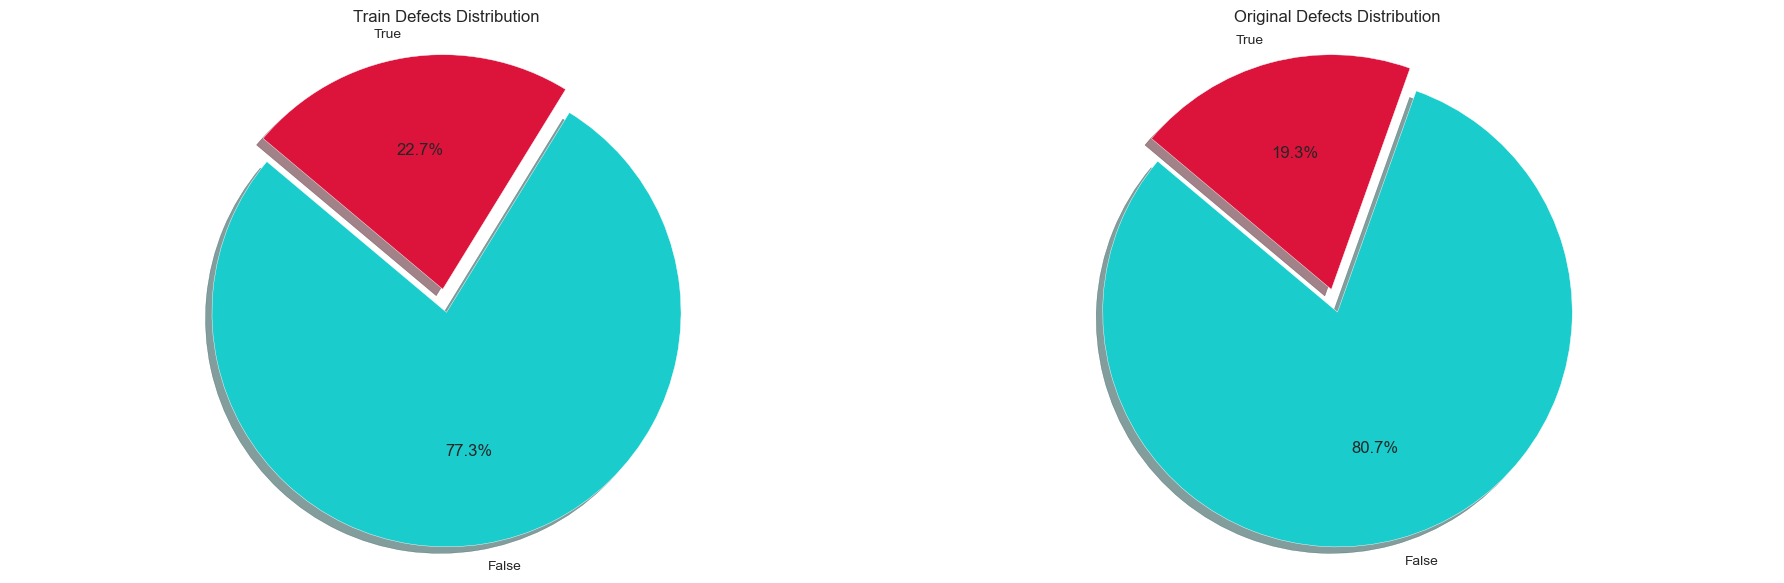

In [4]:
def plot_pie_chart(data, title, ax):
    data_counts = data["defects"].value_counts()
    labels = data_counts.index
    sizes = data_counts.values
    colors = [(0.1, 0.8, 0.8), "crimson"]
    explode = (0.1, 0)

    ax.pie(
        sizes,
        explode=explode,
        labels=labels,
        colors=colors,
        autopct="%1.1f%%",
        shadow=True,
        startangle=140,
    )
    ax.axis("equal")
    ax.set_title(title)


# Create three subplots in a row
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

plot_pie_chart(train_copy, "Train Defects Distribution", axes[0])
plot_pie_chart(original, "Original Defects Distribution", axes[1])

plt.tight_layout()
plt.show()


## 3.2 Numerical Feature Distributions


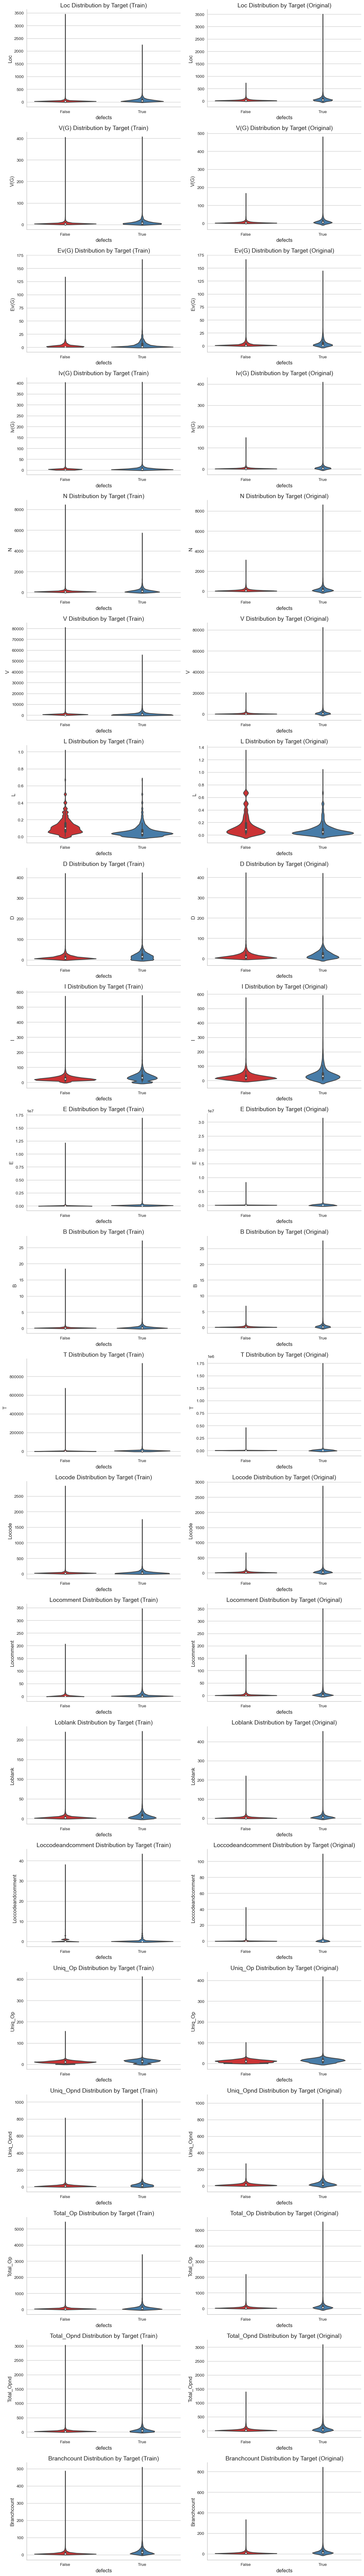

In [5]:
cont_cols = [f for f in train.columns if train[f].dtype !=
             'O' and train[f].nunique() > 2]
n_rows = len(cont_cols)
fig, axs = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))
sns.set_palette("Set1")
for i, col in enumerate(cont_cols):
    sns.violinplot(x='defects', y=col, data=train_copy, ax=axs[i, 0])
    axs[i, 0].set_title(
        f'{col.title()} Distribution by Target (Train)', fontsize=14)
    axs[i, 0].set_xlabel('defects', fontsize=12)
    axs[i, 0].set_ylabel(col.title(), fontsize=12)
    sns.despine()

    sns.violinplot(x='defects', y=col, data=original, ax=axs[i, 1])
    axs[i, 1].set_title(
        f'{col.title()} Distribution by Target (Original)', fontsize=14)
    axs[i, 1].set_xlabel('defects', fontsize=12)
    axs[i, 1].set_ylabel(col.title(), fontsize=12)
    sns.despine()

fig.tight_layout()

plt.show()


## 3.3 Numerical Pair Plots - Original
- [pandas.DataFrame.nunique](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html)
  - 데이터프레임에서 unique한 값의 갯수를 찾아내는함수

<Figure size 1800x1000 with 0 Axes>

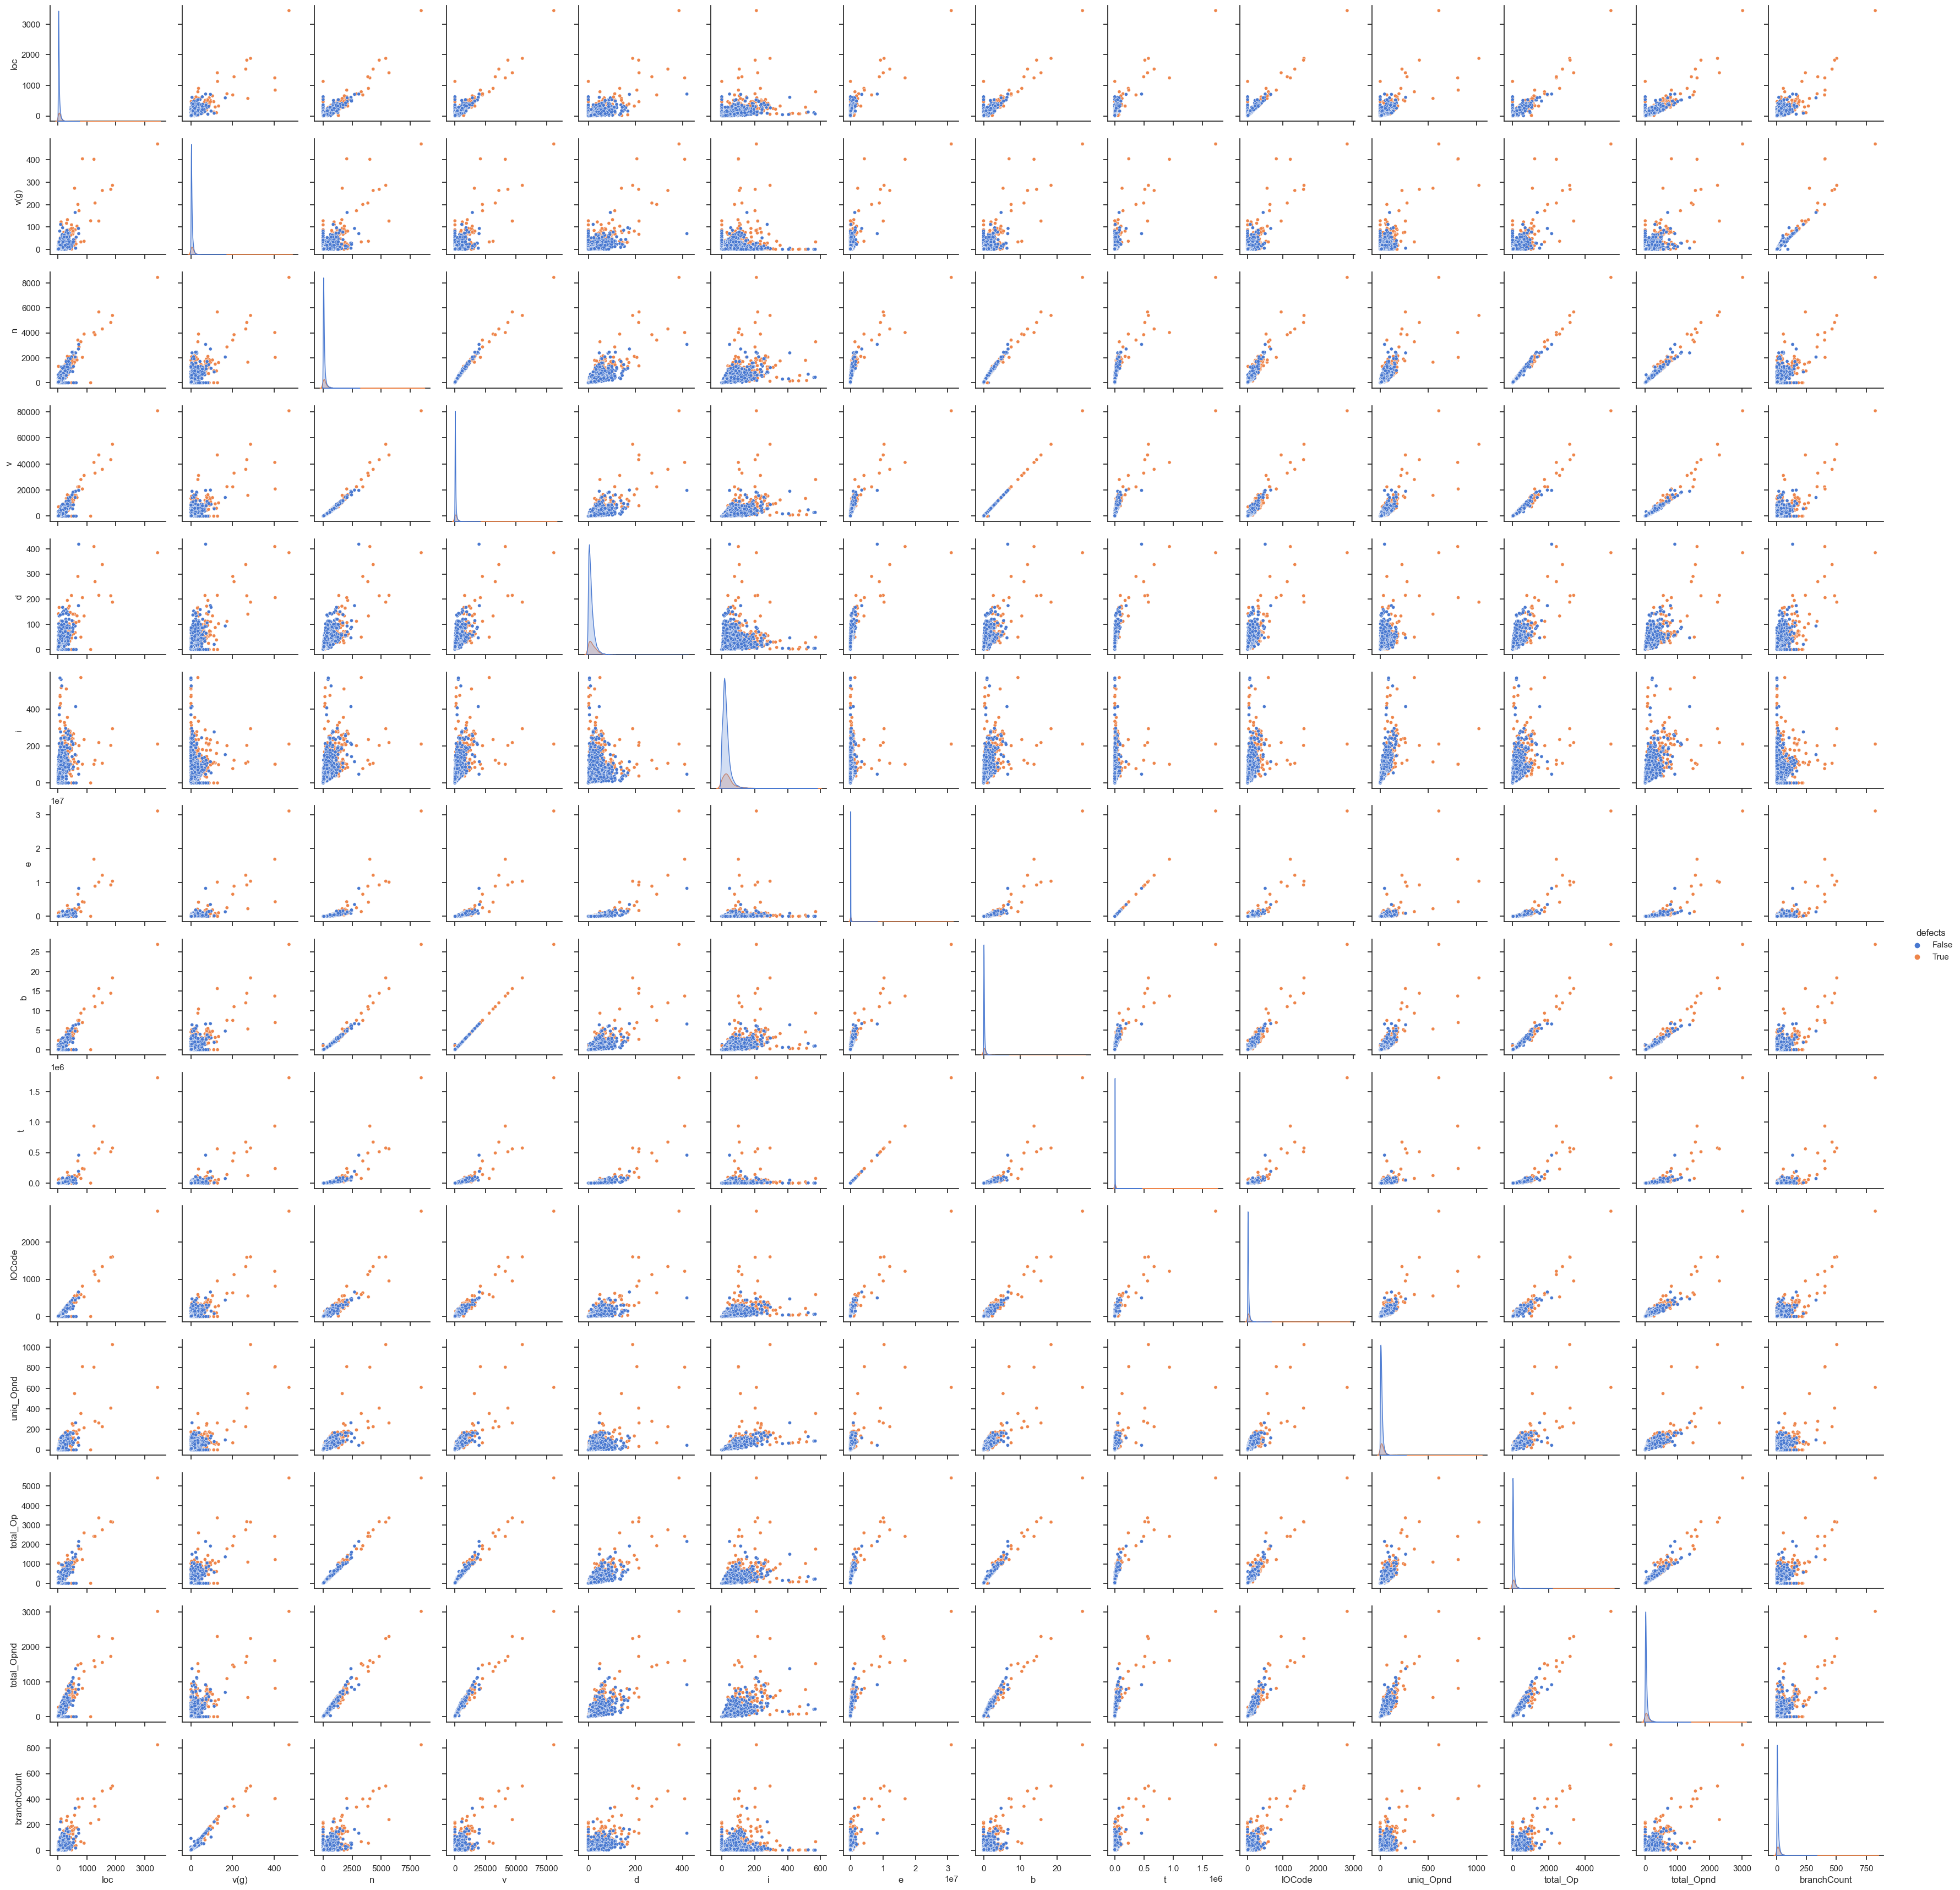

In [8]:
pair_plot_cols = [f for f in cont_cols if original[f].nunique() > 100]

sns.set(font_scale=1)
plt.figure(figsize=(18, 10))
sns.set(style="ticks", color_codes=True)
sns.pairplot(
    data=original,
    vars=pair_plot_cols,
    diag_kind="kde",
    kind="scatter",
    palette="muted",
    plot_kws={"s": 20},
    hue="defects",
)
plt.show()


## 3.4 SVM Bivariate Analysis

- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [ROC-AUC](https://bioinformaticsandme.tistory.com/328) 

In [7]:
feature_pairs = list(combinations(cont_cols, 2))
table = PrettyTable()
table.field_names = ["Feature Pair", "ROC AUC"]

for pair in feature_pairs:
    x_temp = original.loc[:, [pair[0], pair[1]]]
    y_temp = original["defects"]
    model = SVC(gamma="auto")
    model.fit(x_temp, y_temp)
    y_pred = model.predict(x_temp)
    acc = accuracy_score(y_temp, y_pred)
    table.add_row([pair, acc])
table.sortby = "ROC AUC"
table.reversesort = True
print(table)


+--------------------------------------+--------------------+
|             Feature Pair             |      ROC AUC       |
+--------------------------------------+--------------------+
|             ('loc', 'e')             | 0.9566176470588236 |
|              ('v', 'e')              | 0.9500919117647059 |
|              ('i', 'e')              | 0.9479779411764706 |
|              ('n', 'e')              | 0.9463235294117647 |
|           ('e', 'lOCode')            | 0.9449448529411765 |
|         ('e', 'branchCount')         | 0.9446691176470589 |
|          ('e', 'total_Op')           | 0.944485294117647  |
|         ('e', 'total_Opnd')          | 0.9441176470588235 |
|          ('e', 'uniq_Opnd')          | 0.9438419117647059 |
|              ('v', 't')              | 0.9380514705882353 |
|           ('e', 'lOBlank')           | 0.9380514705882353 |
|           ('e', 'uniq_Op')           | 0.9369485294117647 |
|              ('d', 'e')              | 0.9354779411764705 |
|       